# Icevision_obj detection(ATK)

## Install lib

In [1]:
! pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
! pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
! pip install mmdet==2.17.0
! pip install icevision[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#import lib
from icevision.all import *
from PIL import Image, ImageOps
from icevision.models import *

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Upload weight file

In [ ]:
#model : https://github.com/Tanaanan/AOC_ATK_OCR_Classification/blob/main/Weight_model/AOC_weight_97.4.pth

In [4]:
#upload checkpoint path
checkpoint_path = '/content/drive/MyDrive/AI_Builder/Save_result/AOC_weight_97.4.pth'

In [5]:
# The model is automatically recreated in the evaluation mode. To unset that mode, you only need to pass `eval_mode=Fales`)
checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='ross.efficientdet', 
    backbone_name='tf_d2',
    img_size=384, 
    is_coco=False)

# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

# Get model object
# The model is automatically set in the evaluation mode
model = checkpoint_and_model["model"]

# Check device
device=next(model.parameters()).device
device

# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

def img_resize(input_path, output_path, img_size):
  desired_size = img_size
  im = Image.open(input_path)
  im = ImageOps.exif_transpose(im) # fix image rotating
  #im = im.convert('L') #Convert to gray
  old_size = im.size  # old_size[0] is in (width, height) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])
  # use thumbnail() or resize() method to resize the input image

  # thumbnail is a in-place operation

  # im.thumbnail(new_size, Image.ANTIALIAS)

  im = im.resize(new_size, Image.ANTIALIAS)
  # create a new image and paste the resized on it

  new_im = Image.new("RGB", (desired_size, desired_size))
  new_im.paste(im, ((desired_size-new_size[0])//2,
                      (desired_size-new_size[1])//2))

  #display(new_im)

  #Save resize image
  new_im.save(output_path)
  
  print("resize finished!!")


def get_img_detection(img_path):
   
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
  
  return pred_dict['img']

def get_detection(img_path):
 
  #Get_Idcard_detail(file_path=img_path)
  img = PIL.Image.open(img_path)
  img = ImageOps.exif_transpose(img) # fix image rotating

  try:
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  except ValueError:# if image size to small resize it!
    print(f"Image size  not support resizing...")
    img_resize(img_path,img_path,1280)
    pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)

  try:
    labels, acc = pred_dict['detection']['labels'][0], pred_dict['detection']['scores'][0]
    acc = acc * 100
    if labels == "Neg":
      labels = "Negative"
    elif labels == "Pos":
      labels = "Positive"
    print(f"Result : {labels} with {round(acc, 2)}% confidence.")
  except IndexError:
    print("Not found Antigen test kit please take image again!")
    labels = "None"
    acc = 0



load checkpoint from local path: /content/drive/MyDrive/AI_Builder/Save_result/AOC_weight_97.4.pth


06/19/2022 12:33:15 - INFO - timm.models.helpers -   Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth)
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b2_aa-60c94f97.pth


## get detection result

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


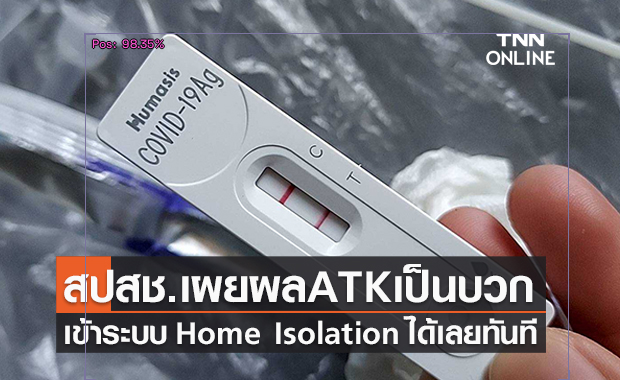

In [7]:
get_img_detection('/content/positive.jpg')

In [9]:
get_detection('/content/positive.jpg')

Result : Positive with 98.35% confidence.


/usr/local/lib/python3.7/dist-packages/effdet/bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


# OCR (Identification card)

## Install lib

In [1]:
!pip install -U Pillow
!pip install editdistance
!pip install easyocr
! pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import editdistance
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import PIL
#import pytesseract as pts
import requests
import easyocr
from pythainlp.util import isthai


def Get_Idcard_detail(file_path):
  raw_data = []
  id_num = {"id_num" : "None"}
  name = file_path
  img = Image.open(name)
  img = ImageOps.exif_transpose(img) # fix image rotating
  #img = img.convert('L') #Convert to gray
  #img.save(name)

  #pytherass
  ''' text = pts.image_to_string(img, lang='tha+eng')
  raw_data = text.split() ''' 

  #Easy OCR
  # Doing OCR. Get bounding boxes.
  reader = easyocr.Reader(['en'])#['th','en']
  bounds = reader.readtext(name)

  split_data = []
  try:
    for data in bounds:
      split_data.append(data[1])
  except:
      print("--------Oops! index out of range-------") 

  raw_data = split_data  



  def get_english(raw_list): # Cut only english var
    eng_name = []
    thai_name = []

    for name in raw_list:
      if isthai(name) == True:
        thai_name.append(name)
      else:
        eng_name.append(name)

    ''' print("\Engname")
    print(eng_name)
    print()
    print("\Thainame")
    print(thai_name) '''
    return eng_name
  
  raw_data = get_english(raw_data)


  def Clear_syntax(raw_list):

    Clean_syntax = ["","#","{","}","=","/","@","#","$","—","|","%","-","(",")","¥", "[", "]", "‘",':',';']

    for k in range(len(Clean_syntax)):
      while (Clean_syntax[k] in raw_list): # remove single symbol
        raw_list.remove(Clean_syntax[k])

    for l in range(len(raw_list)): 
      raw_list[l] = raw_list[l].replace("!","l") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(",",".") #split ! --> l (Error OCR Check)
      raw_list[l] = raw_list[l].replace(" ","") #split " " out from str
      raw_list[l] = raw_list[l].lower() #Set all string to lowercase

    for m in range(len(raw_list)): #Clear symbol in str "Hi/'" --> "Hi"
      for n in range(len(Clean_syntax)):
          raw_list[m] = raw_list[m].replace(Clean_syntax[n],"") 
    return raw_list
  
  raw_data = Clear_syntax(raw_data)
  

  def get_idnum(raw_list):
    id_num = {"id_num" : "None"}
    # 1. normal check 
    for i in range(len(raw_list)): # check if len(list) = 1, 4, 5, 2, 1 (13 digit idcard) and all is int
      try:
        if ((len(raw_list[i]) == 1) and (len(raw_list[i+1]) == 4) and (len(raw_list[i+2]) == 5) and (len(raw_list[i+3]) == 2) and (len(raw_list[i+4]) == 1)) and ((raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4]).isnumeric()):
          id_num["id_num"] = (raw_list[i] + raw_list[i+1] + raw_list[i+2] + raw_list[i+3] + raw_list[i+4])
          break 
      except:
        pass
    
    # 2. Hardcore Check
    if id_num["id_num"] == "None":
      id_count = 0
      index_first = 0
      index_end = 0
      for i in range(len(raw_list)):
        if id_count == 13:
          index_end = i-1 #ลบ 1 index เพราะ ครบ 13 รอบก่อนหน้านี้
          #print(f"index_first == {index_first} index_end == {index_end}")
          #print(f"id = {raw_list[index_first:index_end+1]}")
          id_num["id_num"] = ''.join(raw_list[index_first:index_end+1]) 
          break
        else:
          if raw_list[i].isnumeric() == True and index_first == 0:
            id_count += len(raw_list[i])
            index_first = i
          elif raw_list[i].isnumeric() == True and index_first != 0:
            id_count += len(raw_list[i])
          elif raw_list[i].isnumeric() == False:
            id_count = 0
            index_first = 0
          
    return id_num

  id_num = (get_idnum(raw_data))

      #Complete list name check
  def list_name_check(raw_list):
    sum_list = raw_list
    name_key = ['name', 'lastname']

    #1. name_key check
    if ("name" in sum_list) and ("lastname" in sum_list): # if name and lastname in list pass it!
      pass
    else:
      for i in range(len(name_key)):
        for j in range(len(sum_list)):
          if (editdistance.eval(name_key[i], sum_list[j]) <= 2 ): 
            sum_list[j] = name_key[i]
    
    gender_key = ["mr.", "mrs.", 'master', 'miss']
    #2 gender_key check
    count = 0 # check for break
    for i in range(len(gender_key)):
      for j in range(len(sum_list)):
        if (count == 0):
          try:
            if (sum_list[i] == "name") or (sum_list[i] == "lastname"): # skip "name" and "lastname"
              pass
            else:
              # mr, mrs sensitive case double check with len(gender_key) == len(keyword)
              if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
              elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
          except:
            if (gender_key[i] == "mr." or gender_key[i] == "mrs.") and (editdistance.eval(gender_key[i], sum_list[j]) <= 2 and (len(gender_key[i]) == len(sum_list[j]))): 
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
            elif (gender_key[i] == "master" or gender_key[i] == "miss") and (editdistance.eval(gender_key[i], sum_list[j]) <= 3 ) and (len(gender_key[i]) == len(sum_list[j])):
                sum_list[j] = gender_key[i]
                count+=1
                #print(1)
        else:
          break
    
    return sum_list

  raw_data = list_name_check(raw_data)

  #get_eng_name
  def get_engname(raw_list):
    get_data = raw_list
    engname_list = []

    name_pos = [] 
    lastname_pos = []
    mr_pos = []
    mrs_pos = []

      # check keyword by name, lastname, master, mr, miss, mrs
    for j in range(len(get_data)): #get "name" , "lastname" index
      if "name" == get_data[j]:
        name_pos.append(j)
      elif "lastname" == get_data[j]:
        lastname_pos.append(j)
      elif ("mr." == get_data[j]) or ("master" == get_data[j]):
        mr_pos.append(j)
      elif ("miss" == get_data[j]) or ("mrs." == get_data[j]):
        mrs_pos.append(j)


    if len(name_pos) != 0: #get_engname ex --> ['name', 'master', 'tanaanan', 'lastname', 'chalermpan']
      engname_list = get_data[name_pos[0]:name_pos[0]+6] # select first index กรณีมี "name" มากกว่า 1 ตัว
    elif len(lastname_pos) != 0:
      engname_list = get_data[lastname_pos[0]-3:lastname_pos[0]+3] 
    elif len(mr_pos) != 0:
      engname_list = get_data[mr_pos[0]-1:mr_pos[0]+5]
    elif len(mrs_pos) != 0:
      engname_list = get_data[mrs_pos[0]-1:mrs_pos[0]+5]
    else:
      print("Can't find eng name!!") 

    return engname_list
  
  raw_data = get_engname(raw_data)

  

  
  def split_genkey(raw_list): # remove stringname + gender_key ex. "missjate" -> "jate"
    data = raw_list
    key = ['mrs.','mr.','master','miss']
    name = "" #gen_key name
    name_pos = 0
    gen_index = 0
    gen_type = "" #male / female
    # check keyword
    for key_val in key:
        for each_text in data:
            if (each_text[:len(key_val)] == key_val) or (editdistance.eval(each_text[:len(key_val)],key_val) <= 1 and (len(each_text[:len(key_val)]) == len(key_val))):
                #each_text = each_text[len(key):]
                if (each_text == "name") or (each_text == "lastname"):
                  pass
                else:
                  name = (each_text[:len(key_val)])
                  name_pos = data.index(each_text) # get_index
                  gen_index = len(key_val)
                  """ if (key_val == key[0]) or (key_val == key[1]):
                      gen_type = "male"
                  else:
                      gen_type = "female"  """
                  break
    if (name_pos != 0): 
      data[name_pos] = data[name_pos][gen_index:] # split gender_key on list
      for empty_str in range(data.count('')): # clear "empty string"
        data.remove('')
    return data
  
  raw_data = split_genkey(raw_data)
  
  
  def clean_name_data(raw_list): # delete all single string and int string
    for k in range(len(raw_list)):
      try:
        while ((len(raw_list[k]) <= 2) or (raw_list[k].isnumeric() == True)): # remove single symbol
          raw_list.remove(raw_list[k])
      except IndexError:
        pass
    return raw_list
  
  raw_data = clean_name_data(raw_data)


  def name_sum(raw_list):
    info = {"name" : "None",
            "lastname" : "None"}
    key = ['mr.','mrs.', 'master', 'miss', 'mrs','mr']
    name_pos = 0
    lastname_pos = 0
    for key_val in key: # remove gender_key in string
      if key_val in raw_list:
        raw_list.remove(key_val)
    try:
      for i in range(len(raw_list)):
        if raw_list[i] == "name":
          info["name"] = raw_list[i+1]
          name_pos = i+1
        elif raw_list[i] == "lastname":
          info["lastname"] = raw_list[i+1]
          lastname_pos = i+1
    except:
      pass
    
    # กรณี หาอย่างใดอย่าหนึ่งเจอให้ลองข้ามไปดู 1 index name, "name_val", lastname , "lastname_val"
    if (info["name"] != "None") and (info["lastname"] == "None"):
      try:
        info["lastname"] = raw_list[name_pos+2]
      except:
        pass
    elif (info["lastname"] != "None") and (info["name"] == "None"):
      try:
        info["name"] = raw_list[lastname_pos-2]
      except:
        pass
    
    # remove . on "mr." and "mrs."
    info["name"] = info["name"].replace(".","")
    info["lastname"] = info["lastname"].replace(".","")

    
    return info

  print("Process Completed!.....")
  print(id_num)
  print(name_sum(raw_data))

In [4]:
from PIL import Image, ImageOps

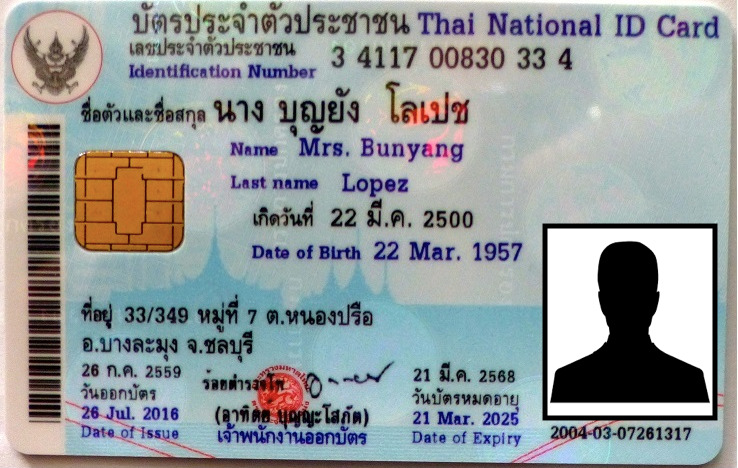

In [6]:
# Image test : https://aiforthai.in.th/files/iappIDcr-front-ex.jpg
Image.open('/content/iappIDcr-front-ex.jpg')

In [5]:
Get_Idcard_detail('/content/iappIDcr-front-ex.jpg')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Process Completed!.....
{'id_num': '3411700830334'}
{'name': 'bunyang', 'lastname': 'lopez'}


# FastAI_img classification (ATK)

## install lib

In [7]:
!pip install -q fastbook 

     |████████████████████████████████| 719 kB 20.8 MB/s 
     |████████████████████████████████| 213 kB 54.8 MB/s 
     |████████████████████████████████| 4.4 MB 47.7 MB/s 
     |████████████████████████████████| 1.2 MB 59.5 MB/s 
     |████████████████████████████████| 362 kB 58.3 MB/s 
     |████████████████████████████████| 61 kB 9.2 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 212 kB 53.2 MB/s 
     |████████████████████████████████| 127 kB 60.2 MB/s 
     |████████████████████████████████| 6.6 MB 45.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
icevision 0.12.0 requires fastcore<1.4,>=1.3.0, but you have fastcore 1.4.5 which is incompatible.
icevision 0.12.0 requires pillow<9,>8.0.0, but you have pillow 9.1.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have fo

In [8]:
from fastbook import *
from fastai.vision import *
from glob import glob
from pathlib import Path
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score



## load model

In [9]:
# model on readme.txt : https://github.com/Tanaanan/AOC_ATK_OCR_Classification/tree/main/Weight_model
learn_inf = load_learner('/content/drive/MyDrive/AI_Builder/Dataset/Weight/ATK+Idcard Efficientb_7 (96 %).pkl')
model = learn_inf.model.eval()

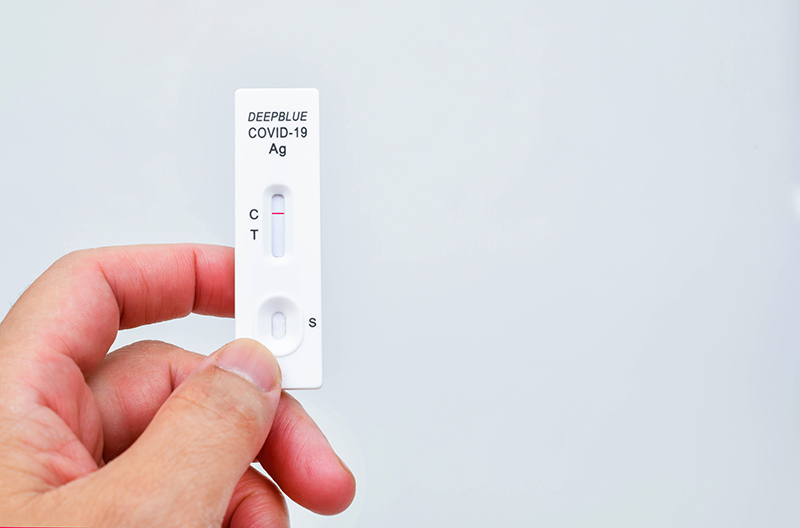

In [31]:
im_path = '/content/negative.jpg'
im = load_image(im_path)#.resize((512, 512))
#im = im.convert('L') #Convert to gray
#im.save(im_path)
im

## get classification result

In [32]:
# Get prediction result

pred = learn_inf.predict(im_path)
cls = int(pred[1]) # 0 = Negative, 1 = Positive
print(pred, cls)


('0_Negative', TensorBase(0), TensorBase([0.9861, 0.0139])) 0


In [33]:
if pred[0] == "1_Positive":
  print("Result : {} with {}% confidence".format(pred[0], round(float(pred[2][1]*100),2)))
if pred[0] == "0_Negative":
  print("Result : {} with {}% confidence".format(pred[0], round(float(pred[2][0]*100),2)))

Result : 0_Negative with 98.61% confidence
